# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

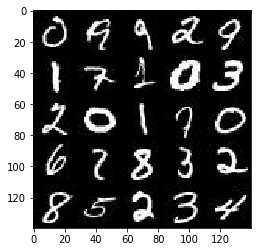

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

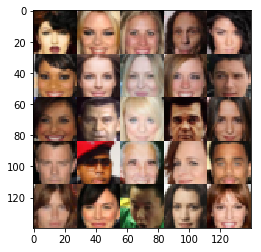

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    keep_prob = 0.8
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Conv1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        rel1 = tf.maximum(alpha * x1, x1)
        rel1 = tf.nn.dropout(rel1, keep_prob)
        
        # Conv2
        x2 = tf.layers.conv2d(rel1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        rel2 = tf.maximum(alpha * bn2, bn2)
        rel2 = tf.nn.dropout(rel2, keep_prob)
        
        # Conv3
        x3 = tf.layers.conv2d(rel2, 256, 5, strides=1, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        rel3 = tf.maximum(alpha * bn3, bn3)
        rel3 = tf.nn.dropout(rel3, keep_prob)
        
        # Conv4
        x4 = tf.layers.conv2d(rel3, 512, 5, strides=1, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(x4, training=True)
        rel4 = tf.maximum(alpha * bn4, bn4)
        rel4 = tf.nn.dropout(rel4, keep_prob)
        
        #Flatten it
        flat = tf.reshape(rel4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    keep_prob = 0.7
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        rel1 = tf.maximum(alpha * bn1, bn1)
        rel1 = tf.nn.dropout(rel1, keep_prob)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(rel1, 256, 3, strides=1, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        rel2 = tf.maximum(alpha * bn2, bn2)
        rel2 = tf.nn.dropout(rel2, keep_prob)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(rel2, 128, 3, strides=1, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        rel3 = tf.maximum(alpha * bn3, bn3)
        rel3 = tf.nn.dropout(rel3, keep_prob)
        # 28x28x128 now
        
        x4 = tf.layers.conv2d_transpose(rel3, 64, 3, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        rel4 = tf.maximum(alpha * bn4, bn4)
        rel4 = tf.nn.dropout(rel4, keep_prob)
        
        # Flatten it
        logits = tf.layers.conv2d_transpose(rel4, out_channel_dim, 3, strides=2, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        
        return out
        
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    tf.reset_default_graph()
    
    # Input placeholders
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    #loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    #optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                # Print steps of 100
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)

   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0744... Generator Loss: 6.9009


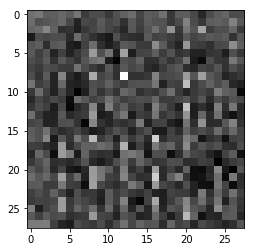

Epoch 1/2... Discriminator Loss: 0.1098... Generator Loss: 4.7087


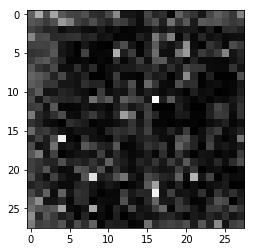

Epoch 1/2... Discriminator Loss: 0.4546... Generator Loss: 2.9729


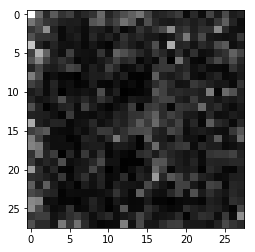

Epoch 1/2... Discriminator Loss: 0.2664... Generator Loss: 3.7003


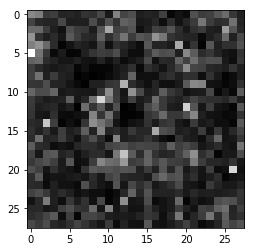

Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 1.2172


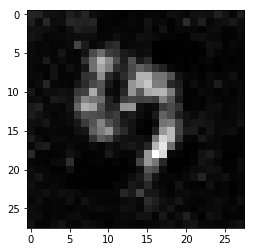

Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 1.5998


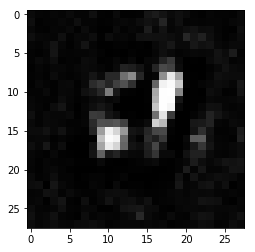

Epoch 1/2... Discriminator Loss: 0.3135... Generator Loss: 4.5801


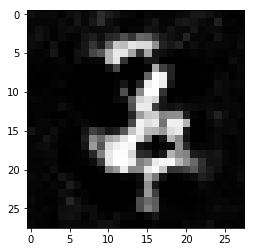

Epoch 1/2... Discriminator Loss: 0.3491... Generator Loss: 3.0274


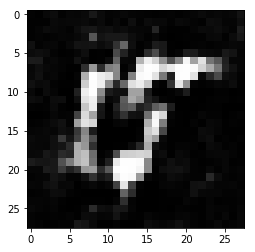

Epoch 1/2... Discriminator Loss: 0.3629... Generator Loss: 2.6728


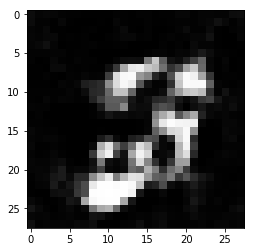

Epoch 2/2... Discriminator Loss: 0.3061... Generator Loss: 3.4504


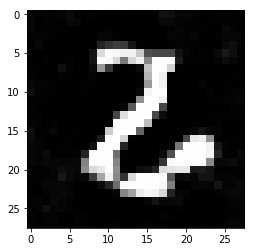

Epoch 2/2... Discriminator Loss: 0.4070... Generator Loss: 2.2107


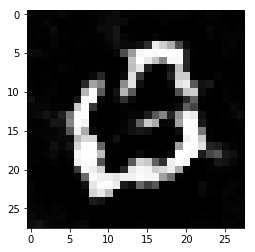

Epoch 2/2... Discriminator Loss: 0.5035... Generator Loss: 1.6036


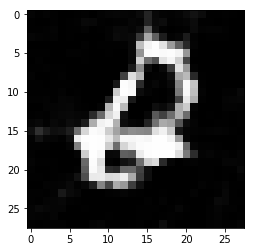

Epoch 2/2... Discriminator Loss: 0.3878... Generator Loss: 1.9506


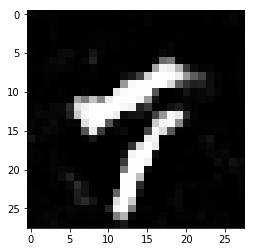

Epoch 2/2... Discriminator Loss: 0.2416... Generator Loss: 4.1402


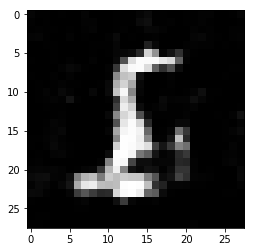

Epoch 2/2... Discriminator Loss: 0.4069... Generator Loss: 3.5812


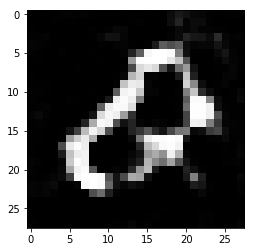

Epoch 2/2... Discriminator Loss: 0.3845... Generator Loss: 1.8990


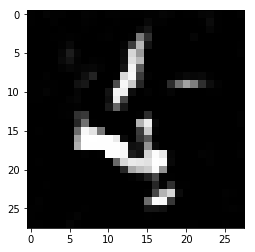

Epoch 2/2... Discriminator Loss: 0.2121... Generator Loss: 2.4630


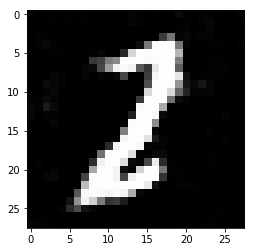

Epoch 2/2... Discriminator Loss: 0.3756... Generator Loss: 1.8182


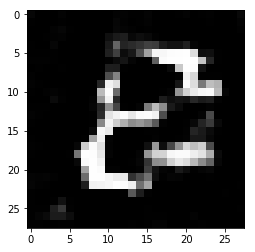

IndexError: list index out of range

In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 8.2395


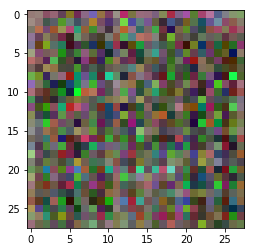

Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 7.4414


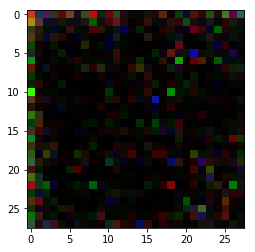

Epoch 1/1... Discriminator Loss: 0.0975... Generator Loss: 4.3828


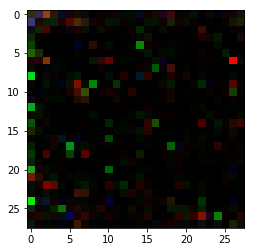

Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 1.8913


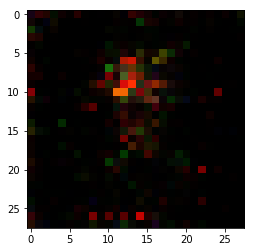

Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 1.5800


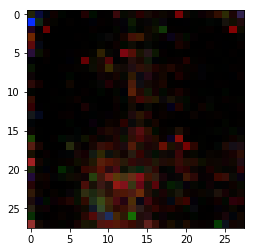

Epoch 1/1... Discriminator Loss: 0.0603... Generator Loss: 4.1106


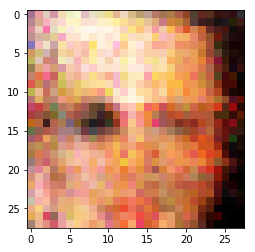

Epoch 1/1... Discriminator Loss: 0.1042... Generator Loss: 5.7276


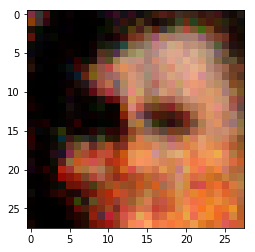

Epoch 1/1... Discriminator Loss: 0.4096... Generator Loss: 3.5118


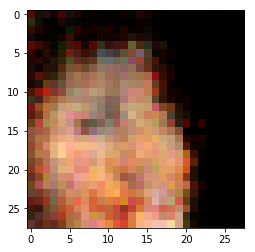

Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 2.5545


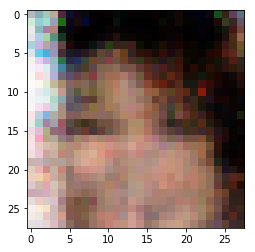

Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 5.2762


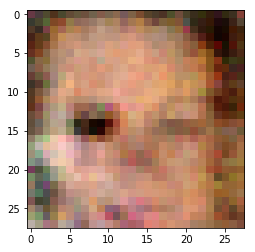

Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 2.0674


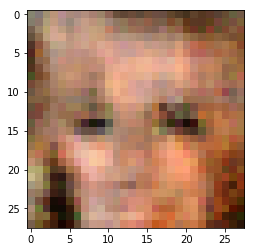

Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 1.0525


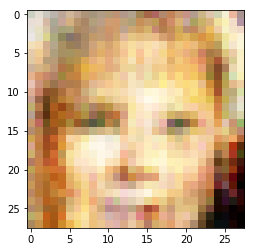

Epoch 1/1... Discriminator Loss: 0.0886... Generator Loss: 4.1525


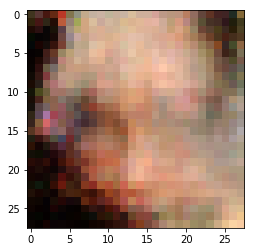

Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 1.2590


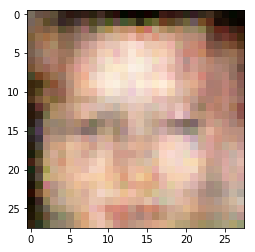

Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 2.5669


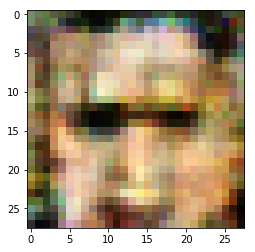

Epoch 1/1... Discriminator Loss: 0.2028... Generator Loss: 3.1102


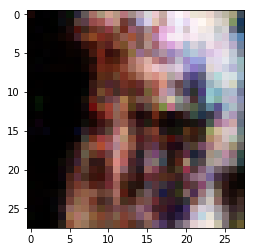

Epoch 1/1... Discriminator Loss: 1.8300... Generator Loss: 0.5465


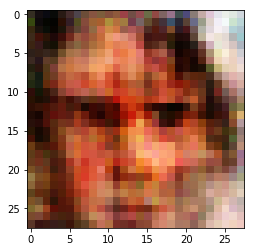

Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 2.9019


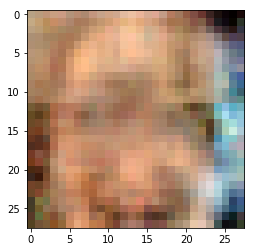

Epoch 1/1... Discriminator Loss: 0.2674... Generator Loss: 3.4148


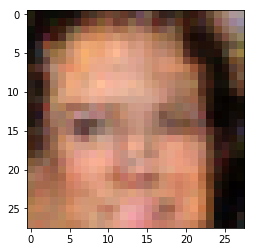

Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.6473


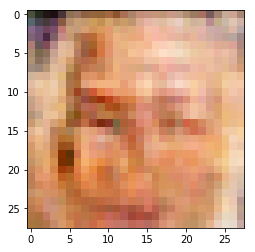

Epoch 1/1... Discriminator Loss: 0.3276... Generator Loss: 2.2344


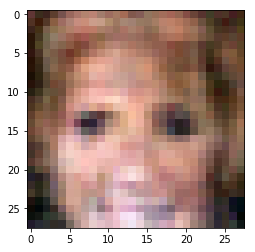

Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 1.9847


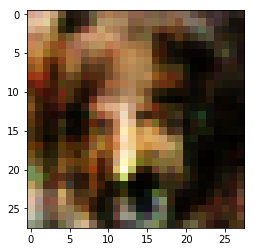

Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.1590


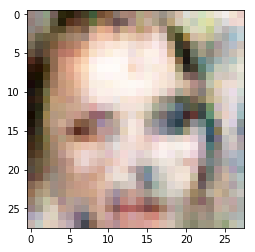

Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6337


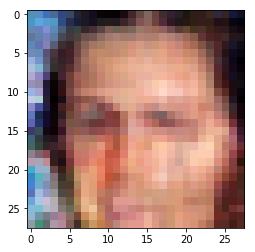

Epoch 1/1... Discriminator Loss: 2.2162... Generator Loss: 0.7432


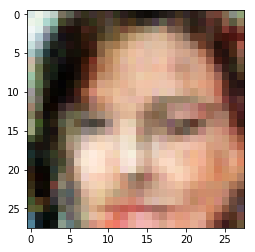

Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 1.8652


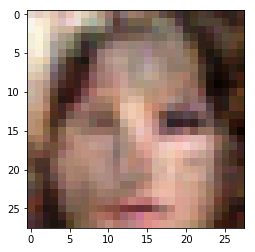

Epoch 1/1... Discriminator Loss: 0.2506... Generator Loss: 3.2620


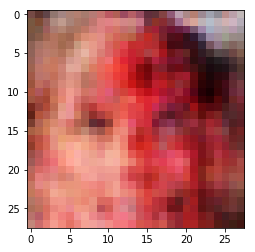

Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 1.9728


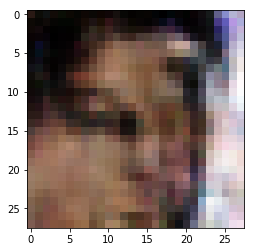

Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 1.5998


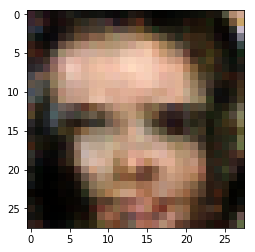

Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 2.2016


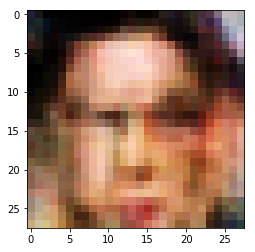

Epoch 1/1... Discriminator Loss: 0.2255... Generator Loss: 1.6684


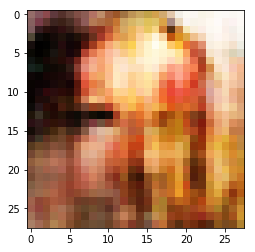

Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8506


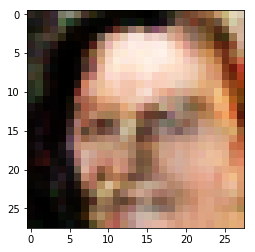

Epoch 1/1... Discriminator Loss: 0.2882... Generator Loss: 3.5968


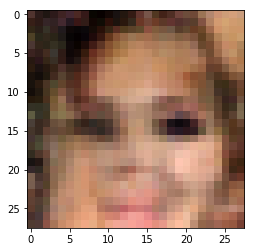

Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.3129


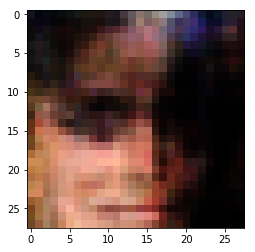

Epoch 1/1... Discriminator Loss: 0.2388... Generator Loss: 1.9942


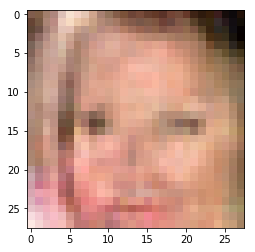

Epoch 1/1... Discriminator Loss: 0.2911... Generator Loss: 3.2033


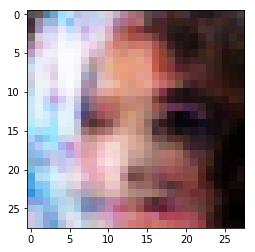

Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 2.8926


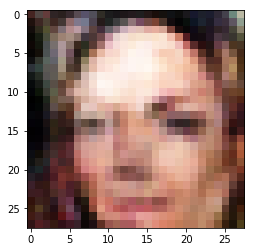

Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 1.6226


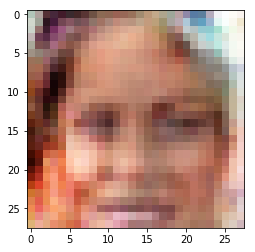

Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 4.1388


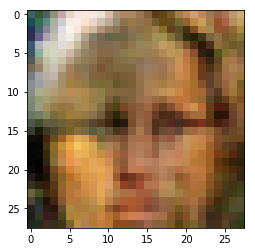

Epoch 1/1... Discriminator Loss: 0.7278... Generator Loss: 3.5925


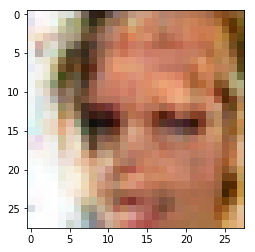

Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 2.1216


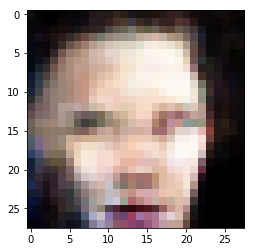

Epoch 1/1... Discriminator Loss: 0.3023... Generator Loss: 2.4032


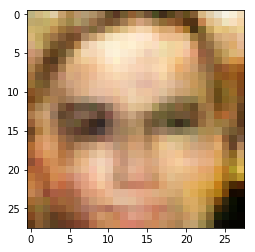

Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 4.6655


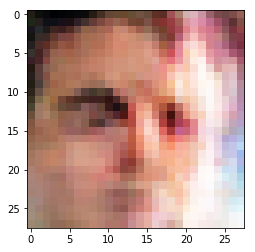

Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.6145


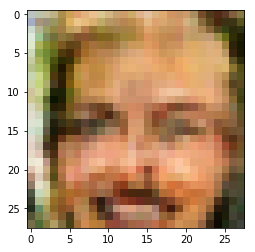

Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 3.5530


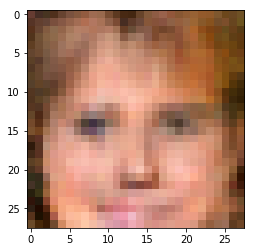

Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 3.0318


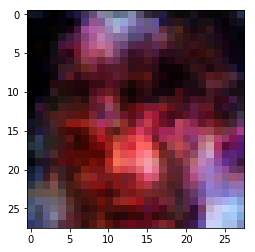

Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 2.5245


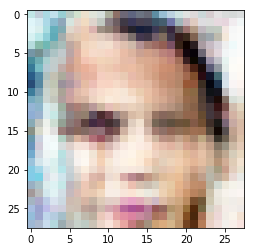

Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 1.4506


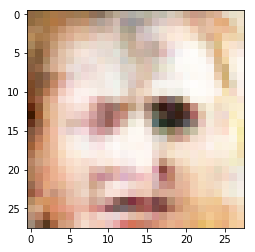

Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 1.9904


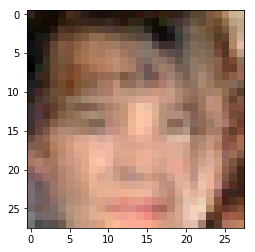

Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 7.4787


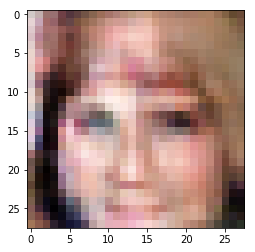

Epoch 1/1... Discriminator Loss: 0.2940... Generator Loss: 5.8501


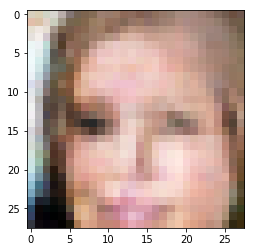

Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.2664


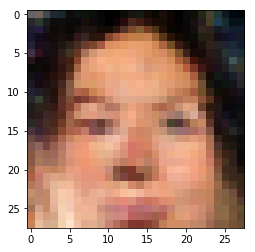

Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 1.7733


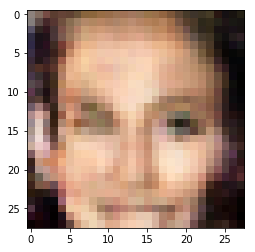

Epoch 1/1... Discriminator Loss: 0.2592... Generator Loss: 3.7954


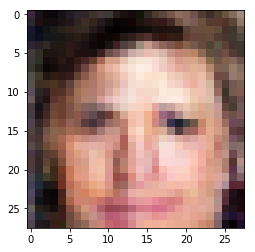

Epoch 1/1... Discriminator Loss: 0.6184... Generator Loss: 4.0195


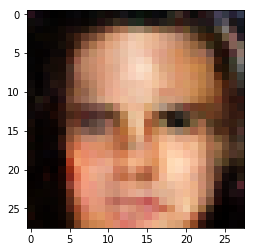

Epoch 1/1... Discriminator Loss: 0.1520... Generator Loss: 3.1110


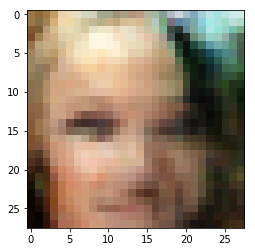

Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 3.3593


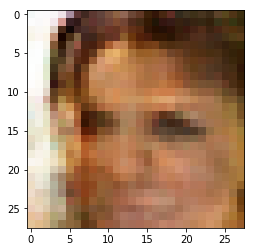

Epoch 1/1... Discriminator Loss: 0.0783... Generator Loss: 4.5692


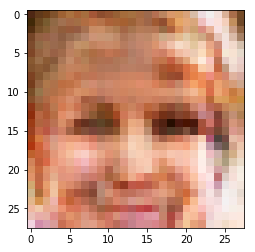

Epoch 1/1... Discriminator Loss: 0.2293... Generator Loss: 3.6164


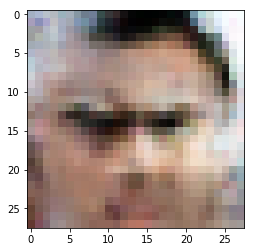

Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 1.7189


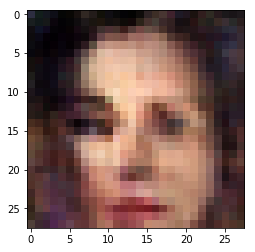

Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 1.6150


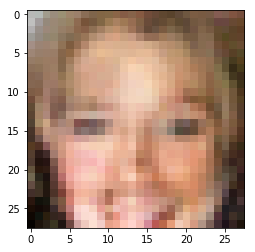

Epoch 1/1... Discriminator Loss: 0.1666... Generator Loss: 3.8199


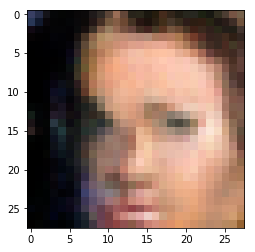

Epoch 1/1... Discriminator Loss: 0.1524... Generator Loss: 3.0933


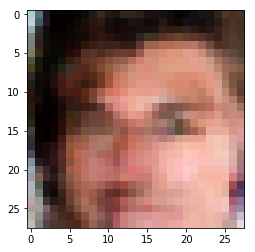

Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 1.9880


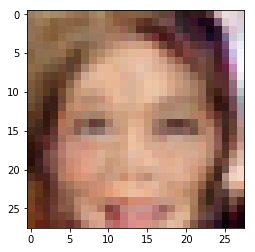

Epoch 1/1... Discriminator Loss: 0.2307... Generator Loss: 1.6862


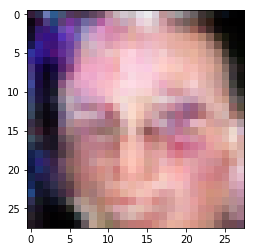

Epoch 1/1... Discriminator Loss: 0.2489... Generator Loss: 2.1284


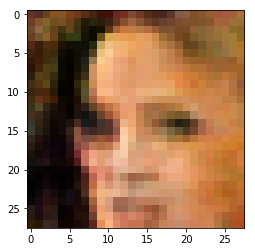

Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.4617


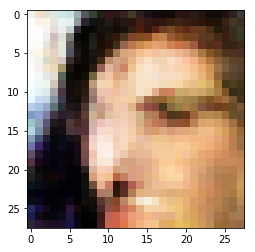

Epoch 1/1... Discriminator Loss: 0.3322... Generator Loss: 2.2124


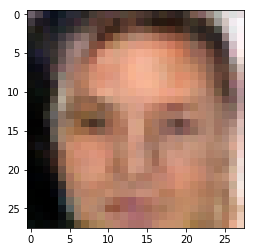

Epoch 1/1... Discriminator Loss: 0.2529... Generator Loss: 4.2586


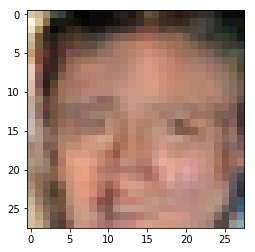

Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 0.8076


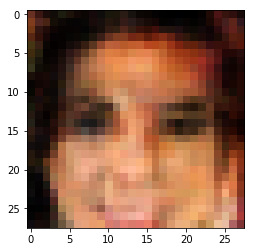

Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 5.2955


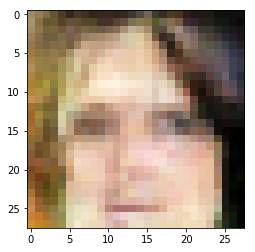

Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 2.8559


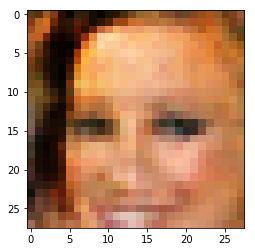

Epoch 1/1... Discriminator Loss: 0.0737... Generator Loss: 3.8032


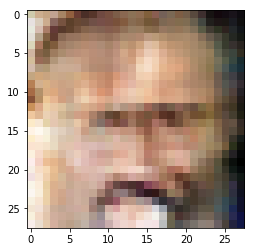

Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.7238


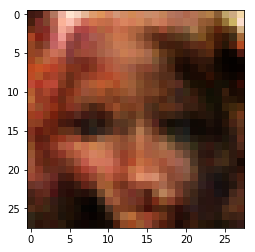

Epoch 1/1... Discriminator Loss: 0.4085... Generator Loss: 1.8738


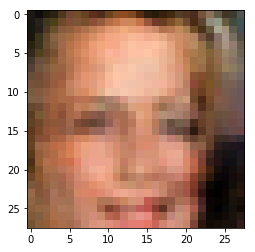

Epoch 1/1... Discriminator Loss: 0.1707... Generator Loss: 2.4043


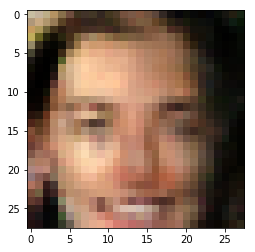

Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 2.6729


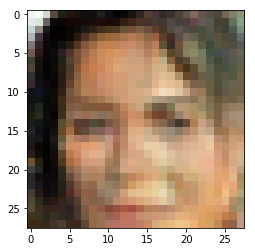

Epoch 1/1... Discriminator Loss: 0.1923... Generator Loss: 2.7300


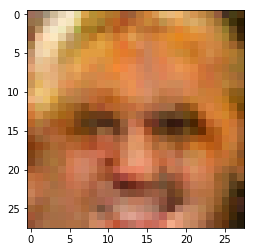

Epoch 1/1... Discriminator Loss: 0.2573... Generator Loss: 3.5481


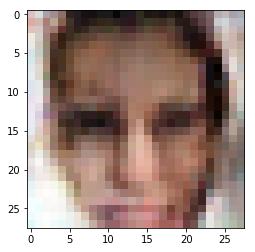

Epoch 1/1... Discriminator Loss: 0.1160... Generator Loss: 4.0458


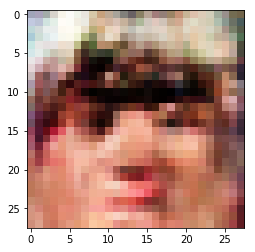

Epoch 1/1... Discriminator Loss: 2.1930... Generator Loss: 0.3436


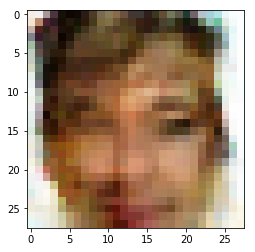

Epoch 1/1... Discriminator Loss: 0.2460... Generator Loss: 3.5708


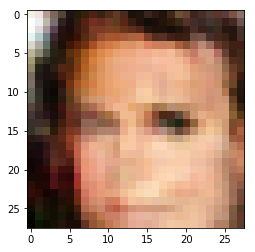

Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.9146


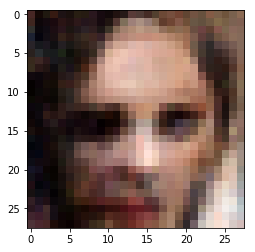

Epoch 1/1... Discriminator Loss: 3.6893... Generator Loss: 5.7062


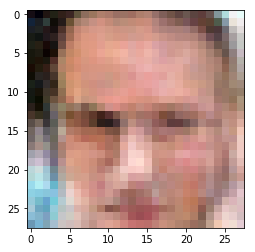

Epoch 1/1... Discriminator Loss: 0.1081... Generator Loss: 3.9547


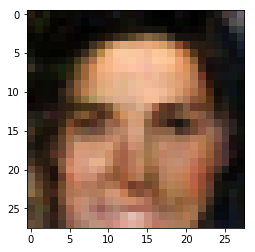

Epoch 1/1... Discriminator Loss: 0.1073... Generator Loss: 3.7929


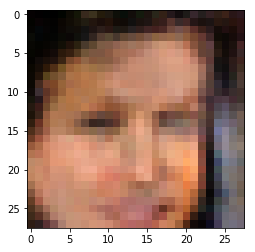

Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 2.3701


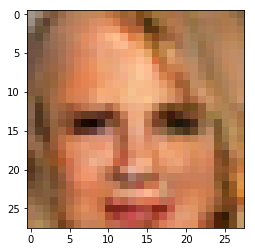

Epoch 1/1... Discriminator Loss: 0.0518... Generator Loss: 5.0093


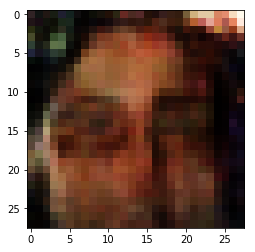

Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.3480


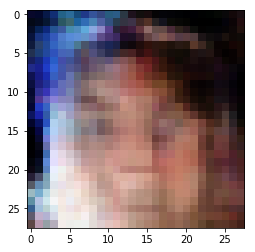

Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 5.5872


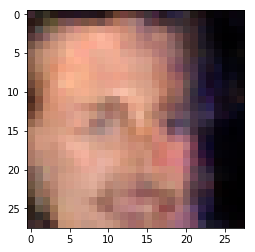

Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 5.1505


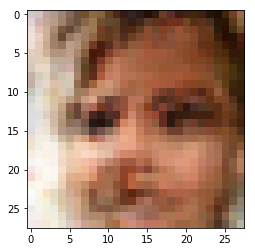

Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 5.9692


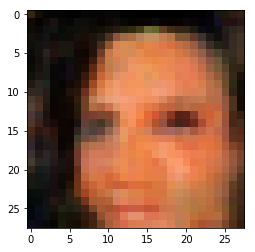

Epoch 1/1... Discriminator Loss: 0.2194... Generator Loss: 2.1707


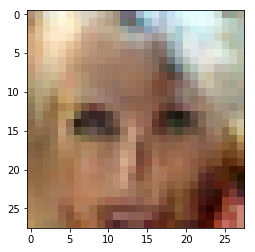

Epoch 1/1... Discriminator Loss: 0.2619... Generator Loss: 4.2978


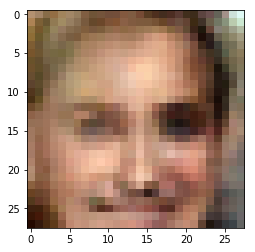

Epoch 1/1... Discriminator Loss: 1.7786... Generator Loss: 7.2898


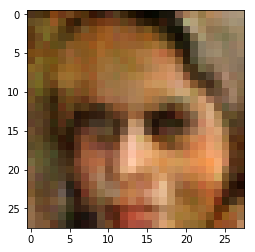

Epoch 1/1... Discriminator Loss: 0.5245... Generator Loss: 5.5448


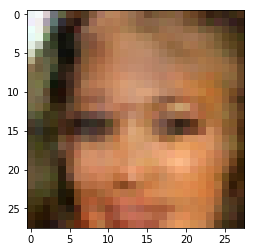

Epoch 1/1... Discriminator Loss: 0.1601... Generator Loss: 4.5776


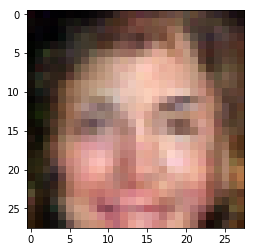

Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 1.7033


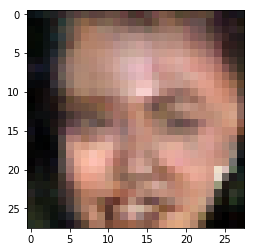

Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 1.8946


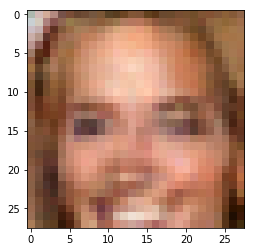

Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 1.0959


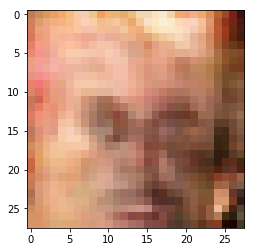

Epoch 1/1... Discriminator Loss: 0.0386... Generator Loss: 4.6943


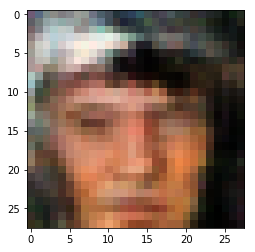

Epoch 1/1... Discriminator Loss: 0.1379... Generator Loss: 2.1227


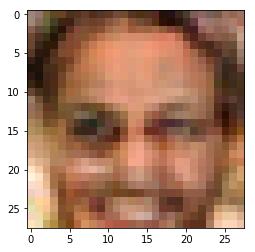

Epoch 1/1... Discriminator Loss: 0.2349... Generator Loss: 2.9140


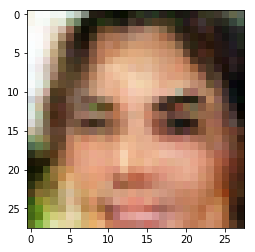

Epoch 1/1... Discriminator Loss: 1.6184... Generator Loss: 1.0257


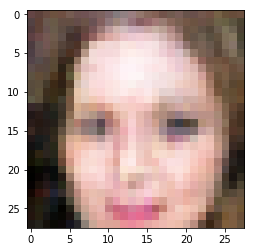

Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 1.3668


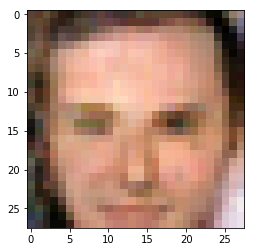

Epoch 1/1... Discriminator Loss: 0.2209... Generator Loss: 3.9200


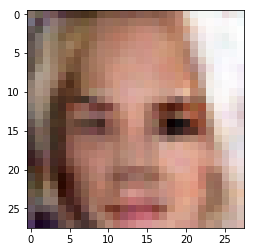

Epoch 1/1... Discriminator Loss: 0.1362... Generator Loss: 2.0361


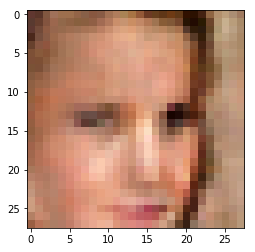

Epoch 1/1... Discriminator Loss: 0.1090... Generator Loss: 3.8160


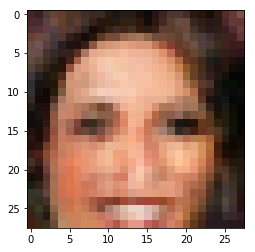

Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.6493


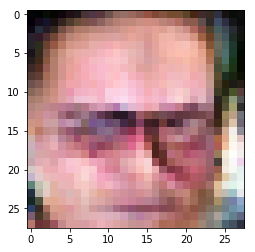

Epoch 1/1... Discriminator Loss: 0.3001... Generator Loss: 3.3181


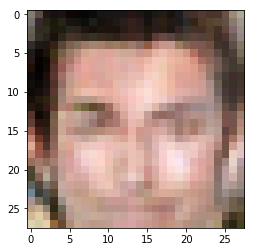

Epoch 1/1... Discriminator Loss: 0.2448... Generator Loss: 3.6683


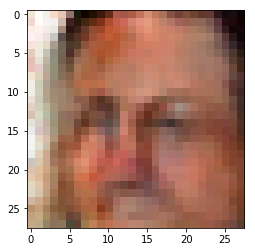

Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 5.0298


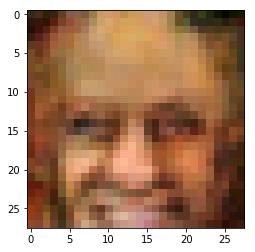

Epoch 1/1... Discriminator Loss: 0.1502... Generator Loss: 2.3537


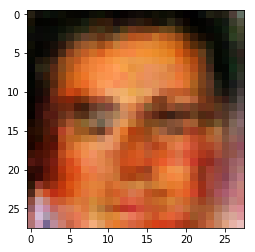

Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 2.4753


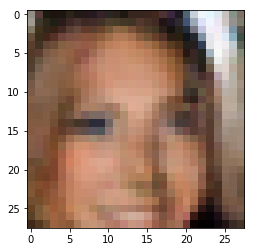

Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 6.4846


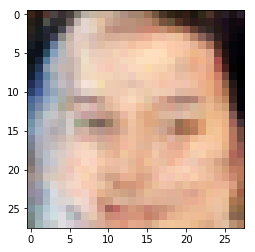

Epoch 1/1... Discriminator Loss: 2.0139... Generator Loss: 0.7205


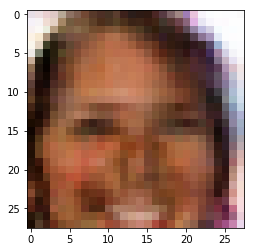

Epoch 1/1... Discriminator Loss: 0.1745... Generator Loss: 2.8405


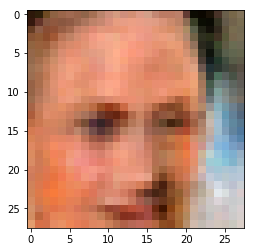

Epoch 1/1... Discriminator Loss: 0.2779... Generator Loss: 3.0794


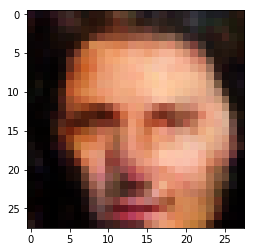

Epoch 1/1... Discriminator Loss: 0.2209... Generator Loss: 3.2575


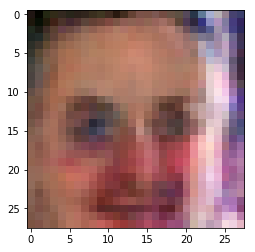

Epoch 1/1... Discriminator Loss: 0.1505... Generator Loss: 5.8044


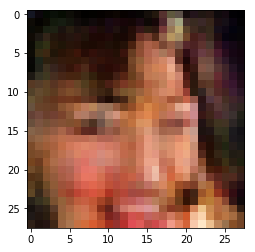

Epoch 1/1... Discriminator Loss: 0.1256... Generator Loss: 4.0938


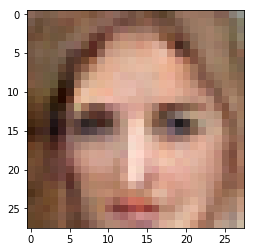

Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 1.1705


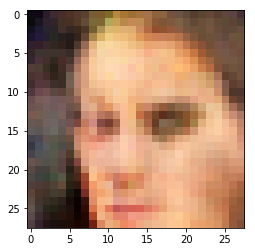

Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 2.4403


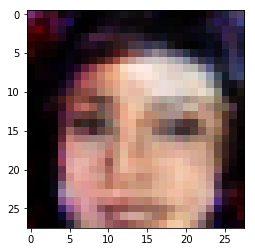

Epoch 1/1... Discriminator Loss: 0.0597... Generator Loss: 5.6735


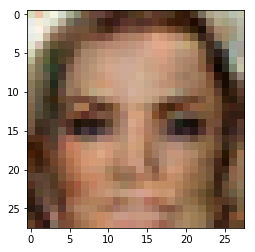

Epoch 1/1... Discriminator Loss: 0.5664... Generator Loss: 1.2257


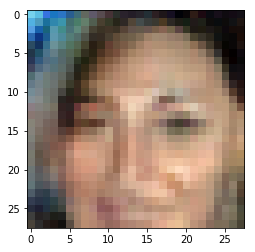

Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 3.0789


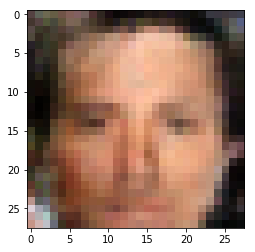

IndexError: list index out of range

In [13]:
batch_size = 16
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.